In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import time
import random

device = torch.device("cpu")
print("Używane urządzenie:", device)


Używane urządzenie: cpu


In [11]:
# ZMIANA 2: Dane wejściowe
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),  # [OK]
    transforms.RandomHorizontalFlip(),  # [ADDED] augmentacja
    transforms.RandomRotation(10),  # [ADDED]
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder('data/train', transform=transform)
val_dataset = datasets.ImageFolder('data/val', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

emotion_labels = {
    0: "angry",
    1: "fear",
    2: "happy",
    3: "sad",
    4: "surprise",
    5: "neutral"
}
print("Label map:", emotion_labels)


Label map: {0: 'angry', 1: 'fear', 2: 'happy', 3: 'sad', 4: 'surprise', 5: 'neutral'}


In [12]:
# ZMIANA 1: num_classes = 6
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=6):  # [MODIFIED]
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  # [MODIFIED] więcej kanałów
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # [MODIFIED]
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # [ADDED]
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 6 * 6, 256)  # [MODIFIED]
        self.dropout = nn.Dropout(0.3)  # [MODIFIED] zwiększenie dropout
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [ADDED]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EmotionCNN(num_classes=6).to(device)



In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)  # [MODIFIED]
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # [ADDED]
num_epochs = 20  # [MODIFIED]

train_losses = []
val_losses = []

def evaluate(loader, model):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = evaluate(val_loader, model)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Time: {time.time()-start:.2f}s")
    scheduler.step()  # [ADDED]

Epoch 1/20 | Train Loss: 1.6623 | Val Loss: 1.4310 | Val Acc: 44.81% | Time: 145.50s
Epoch 2/20 | Train Loss: 1.4367 | Val Loss: 1.3327 | Val Acc: 47.95% | Time: 142.50s
Epoch 3/20 | Train Loss: 1.3788 | Val Loss: 1.3244 | Val Acc: 46.50% | Time: 153.78s
Epoch 4/20 | Train Loss: 1.3384 | Val Loss: 1.2696 | Val Acc: 51.54% | Time: 149.38s
Epoch 5/20 | Train Loss: 1.3112 | Val Loss: 1.2217 | Val Acc: 52.82% | Time: 148.53s
Epoch 6/20 | Train Loss: 1.2603 | Val Loss: 1.1883 | Val Acc: 54.46% | Time: 148.08s
Epoch 7/20 | Train Loss: 1.2460 | Val Loss: 1.1798 | Val Acc: 53.84% | Time: 145.44s
Epoch 8/20 | Train Loss: 1.2270 | Val Loss: 1.1694 | Val Acc: 55.25% | Time: 143.62s
Epoch 9/20 | Train Loss: 1.2201 | Val Loss: 1.1603 | Val Acc: 54.80% | Time: 147.27s
Epoch 10/20 | Train Loss: 1.2071 | Val Loss: 1.1561 | Val Acc: 55.36% | Time: 151.58s
Epoch 11/20 | Train Loss: 1.1779 | Val Loss: 1.1250 | Val Acc: 56.33% | Time: 140.72s
Epoch 12/20 | Train Loss: 1.1671 | Val Loss: 1.1210 | Val Acc: 

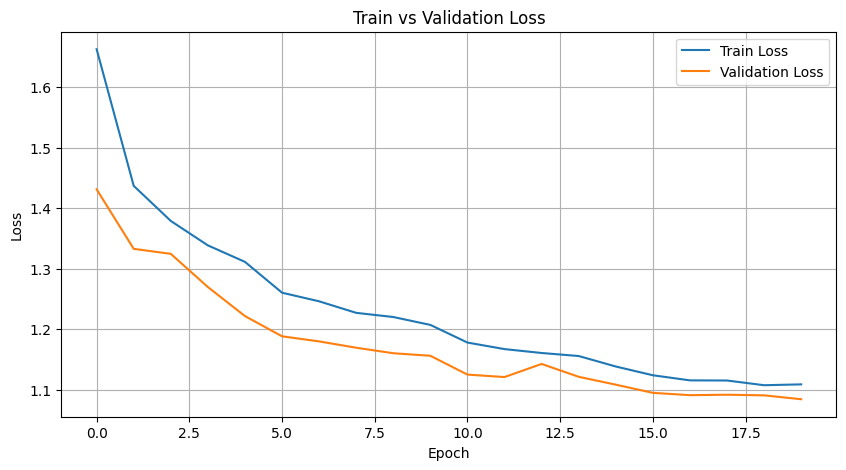

Test Accuracy: 0.5880
Precision (weighted): 0.5735
Recall (weighted): 0.5880
F1 Score (weighted): 0.5742


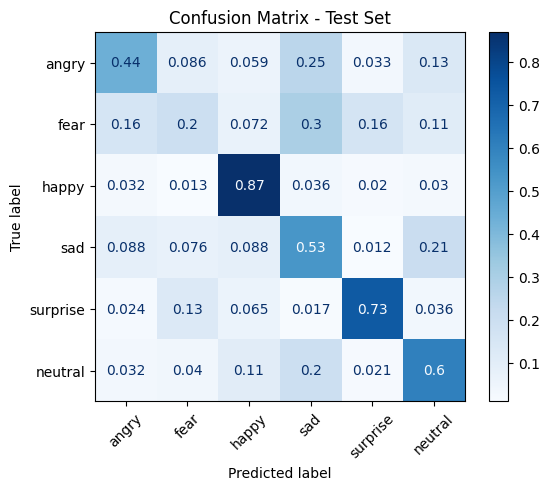

In [14]:
# Wykres strat
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Obliczenie metryk na zbiorze testowym
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Macierz pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=emotion_labels.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45)
plt.show()

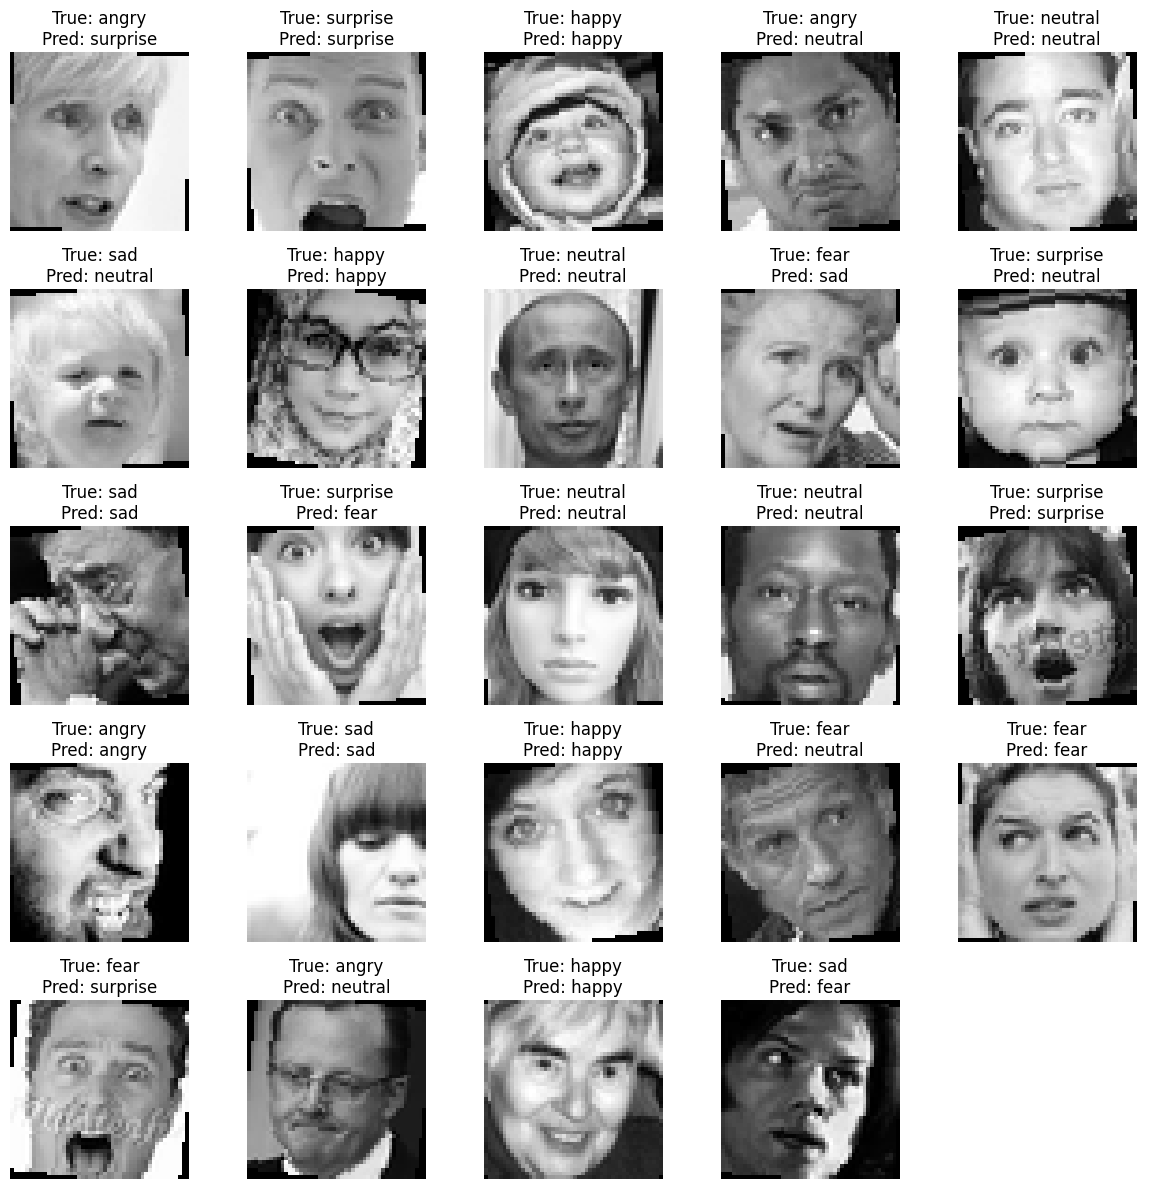

In [15]:
def visualize_predictions(model, dataloader, label_map, num_images=25):
    model.eval()
    
    images_list = []
    labels_list = []

    class_images = {class_id: [] for class_id in range(len(label_map))}
    
    # Zbieramy obrazy z różnych klas
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        for i in range(len(labels)):
            class_images[labels[i].item()].append(images[i].cpu())
        
        # Sprawdzamy, czy mamy już odpowiednią ilość obrazów z różnych klas
        if all(len(class_images[class_id]) >= num_images // len(label_map) for class_id in range(len(label_map))):
            break

    selected_images = []
    selected_labels = []

    # Wystarczająca liczbę obrazów z każdej klasy
    for class_id, images in class_images.items():
        if len(images) >= num_images // len(label_map):
            selected_images.extend(random.sample(images, num_images // len(label_map)))
            selected_labels.extend([class_id] * (num_images // len(label_map)))

    # Jeżeli nie, dostosuj 'num_images'
    total_images = len(selected_images)
    if total_images < num_images:
        num_images = total_images 

    # Losowo permutujemy obrazy i etykiety
    indices = torch.randperm(len(selected_images)).tolist()
    selected_images = [selected_images[i] for i in indices]
    selected_labels = [selected_labels[i] for i in indices]

    rows = (num_images + 4) // 5 
    cols = min(num_images, 5) 

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    with torch.no_grad():
        inputs = torch.stack(selected_images).to(device)
        labels_tensor = torch.tensor(selected_labels).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Zabezpieczenie przed przekroczeniem zakresu
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(selected_images[i].squeeze(), cmap='gray')
        ax.set_title(f"True: {label_map[labels_tensor[i].item()]}\nPred: {label_map[predicted[i].item()]}")
        ax.axis('off')

    #puste osie
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, emotion_labels)